In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import date, datetime, timedelta
from scipy.stats import ks_2samp, mannwhitneyu#, anderson_ksamp
sns.set_theme(style="ticks")
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# parameters

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# load data

In [5]:
# load mass event data
match_data = pd.read_csv('data/metadata/event_data.csv')
match_data['day'] = [d.date() for d in pd.to_datetime(match_data.day)]

In [6]:
data = pd.read_csv('data/fig6/follow_didpairs.csv')
data['day'] = [d.date() for d in pd.to_datetime(data.day)]
data['stime'] = pd.to_datetime(data.stime)
dmin = data.day.min()
data['tt2'] = data.day.apply(lambda d: (d-dmin).days)*24*6 + data.stime.dt.hour*6 + (data.stime.dt.minute//10)
print(data.tt2.min(), data.tt2.max())

0 14111


In [7]:
(data.day.max()-dmin).days*24*6 + (24-1)*6 + (6-1)

14111

# analyses

In [8]:
# stability: 0 = random pair, 1 = stable pair
randstab = pd.DataFrame(data.groupby('pair').day.apply(lambda x: 0 if len(set(x))==1 else 1)).reset_index()
randstab = randstab.rename(columns={'tt':'stability','day':'stability','tt2':'stability'})
randstab

,pair,stability
0,00002996ED618C7A838A2DB70DDF751B_46A22C0ACCCB8...,0
1,00002996ED618C7A838A2DB70DDF751B_67B9CE0EE4E50...,0
2,00002996ED618C7A838A2DB70DDF751B_75320A28578ED...,0
3,00002996ED618C7A838A2DB70DDF751B_850B7F25E4122...,0
4,00006F120DEA8954E745E3D3AD098429_0189688F268EE...,0
...,...,...
2074337,FF9DE8B9584A8DDD4AA134CB4B355035_FFF130873E785...,1
2074338,FFA8BEEF4F0F178A55BCF24C50760A8F_FFD6396074342...,0
2074339,FFC988D2203B66E3A13C6C9C72B02902_FFE2BFC3655DD...,0
2074340,FFE08AD5C2843CF85D5070D2D041771B_FFF9A8C758711...,0


In [9]:
data = pd.read_csv('data/fig6/follow_didpairs_cities.csv')
data['day'] = [d.date() for d in pd.to_datetime(data.day)]
data['stime'] = pd.to_datetime(data.stime)
dmin = data.day.min()
data['tt2'] = data.day.apply(lambda d: (d-dmin).days)*24*6 + data.stime.dt.hour*6 + (data.stime.dt.minute//10)
print(data.tt2.min(), data.tt2.max())

0 14110


In [10]:
match_base = match_data[['day','city','area_id']].copy(deep=True)
match_base['day'] = [d-timedelta(7) for d in match_base.day]
match_base['area_id'] = np.nan
len(match_base)

195

In [11]:
dist_cmp_pos = data.merge(match_data[match_data.day>=di+timedelta(7)][['day','city','area_id']], on=['day','city'])
dist_cmp_pos['event'] = True
dist_cmp_neg = data.merge(match_base[['day','city','area_id']], on=['day','city'])
dist_cmp_neg['event'] = False
dist_cmp = pd.concat([dist_cmp_pos, dist_cmp_neg]).merge(randstab, on='pair')
daily_dur = dist_cmp.groupby(['day','pair']).tt2.apply(lambda x: len(set(x))).reset_index().rename(columns={'tt2':'dur'})
dist_cmp = dist_cmp.merge(daily_dur, on=['day','pair'])
dist_cmp

,day,stime,city,lon,lat,pair,dhome1,dhome2,dhometohome,tt,tt2,area_id,event,stability,dur
0,2024-06-29,2024-06-29 14:00:00+00:00,München,11.520118,48.072701,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,76519.645417,8685.750235,79814.210744,8868,8868,41.0,True,1,14
1,2024-06-29,2024-06-29 14:10:00+00:00,München,11.507385,48.078323,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,77270.036705,7641.653688,79814.210744,8869,8869,41.0,True,1,14
2,2024-06-29,2024-06-29 10:10:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,79815.478185,2.638243,79814.210744,8845,8845,41.0,True,1,14
3,2024-06-29,2024-06-29 10:30:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,79815.478185,2.638243,79814.210744,8847,8847,41.0,True,1,14
4,2024-06-29,2024-06-29 10:40:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,79815.478185,2.638243,79814.210744,8848,8848,41.0,True,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287376,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.022968,53.663436,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,128.168244,192.303780,150.977767,1638,1638,NaN,False,0,1
287377,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.023218,53.663995,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,187.462301,252.738473,150.977767,1638,1638,NaN,False,0,1
287378,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.024469,53.666794,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,503.303671,568.290469,150.977767,1638,1638,NaN,False,0,1
287379,2024-05-10,2024-05-10 04:20:00+00:00,Hamburg,10.057263,53.673110,00CCA0C8E3272BCD09120A85EE70F8E4_8977DDD0BCFAA...,12188.556809,8439.641965,3787.348027,1610,1610,NaN,False,0,1


In [12]:
dist_cmp['dhome1'], dist_cmp['dhome2'] = np.where(dist_cmp['dhome1'] > dist_cmp['dhome2'],\
                                                  (dist_cmp['dhome2'], dist_cmp['dhome1']),\
                                                  (dist_cmp['dhome1'], dist_cmp['dhome2']))
dist_cmp['dhome1'] /= 1e3
dist_cmp['dhome2'] /= 1e3
dist_cmp['dhometohome'] /= 1e3
dist_cmp['dur'] *= 1e1
dist_cmp

,day,stime,city,lon,lat,pair,dhome1,dhome2,dhometohome,tt,tt2,area_id,event,stability,dur
0,2024-06-29,2024-06-29 14:00:00+00:00,München,11.520118,48.072701,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,8.685750,76.519645,79.814211,8868,8868,41.0,True,1,140.0
1,2024-06-29,2024-06-29 14:10:00+00:00,München,11.507385,48.078323,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,7.641654,77.270037,79.814211,8869,8869,41.0,True,1,140.0
2,2024-06-29,2024-06-29 10:10:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,0.002638,79.815478,79.814211,8845,8845,41.0,True,1,140.0
3,2024-06-29,2024-06-29 10:30:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,0.002638,79.815478,79.814211,8847,8847,41.0,True,1,140.0
4,2024-06-29,2024-06-29 10:40:00+00:00,München,11.453307,48.136712,DC2CC16E6DA1A10CA647F2FA5FB337F4_EE320CAE6836E...,0.002638,79.815478,79.814211,8848,8848,41.0,True,1,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287376,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.022968,53.663436,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,0.128168,0.192304,0.150978,1638,1638,NaN,False,0,10.0
287377,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.023218,53.663995,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,0.187462,0.252738,0.150978,1638,1638,NaN,False,0,10.0
287378,2024-05-10,2024-05-10 09:00:00+00:00,Hamburg,10.024469,53.666794,DCA94FF36D47C4F1C108CE84C29C52AD_E0A007C5EF3C7...,0.503304,0.568290,0.150978,1638,1638,NaN,False,0,10.0
287379,2024-05-10,2024-05-10 04:20:00+00:00,Hamburg,10.057263,53.673110,00CCA0C8E3272BCD09120A85EE70F8E4_8977DDD0BCFAA...,8.439642,12.188557,3.787348,1610,1610,NaN,False,0,10.0


In [13]:
dist_cmp[dist_cmp.city=='Gelsenkirchen'].dhome2.max()

534.6528345758231

In [14]:
dist_cmp.dhome2.max()

754.4586184250205

In [15]:
dist_cmp[dist_cmp.city=='Gelsenkirchen'].dhometohome.max()

741.6465928836146

In [16]:
dist_cmp.dhometohome.max()

799.3790716999761

In [17]:
len(set(dist_cmp[(dist_cmp.city=='Gelsenkirchen') & (dist_cmp.event==True)].day))

17

In [18]:
len(set(dist_cmp[(dist_cmp.city=='Gelsenkirchen') & (dist_cmp.event==False)].day))

17

In [19]:
len(set(dist_cmp[dist_cmp.event==True].day))

67

In [20]:
len(set(dist_cmp[dist_cmp.event==False].day))

67

In [21]:
days_here = set(dist_cmp[dist_cmp.event==False].day)
len(days_here)

67

In [22]:
len(set([(city, day) for city, day, event in zip(dist_cmp.city, dist_cmp.day, dist_cmp.event) if event==True]))

153

In [23]:
len(set([(city, day) for city, day, event in zip(dist_cmp.city, dist_cmp.day, dist_cmp.event) if event==False]))

153

dist_cmp.dur.hist()
plt.yscale('log')

## 10 cities

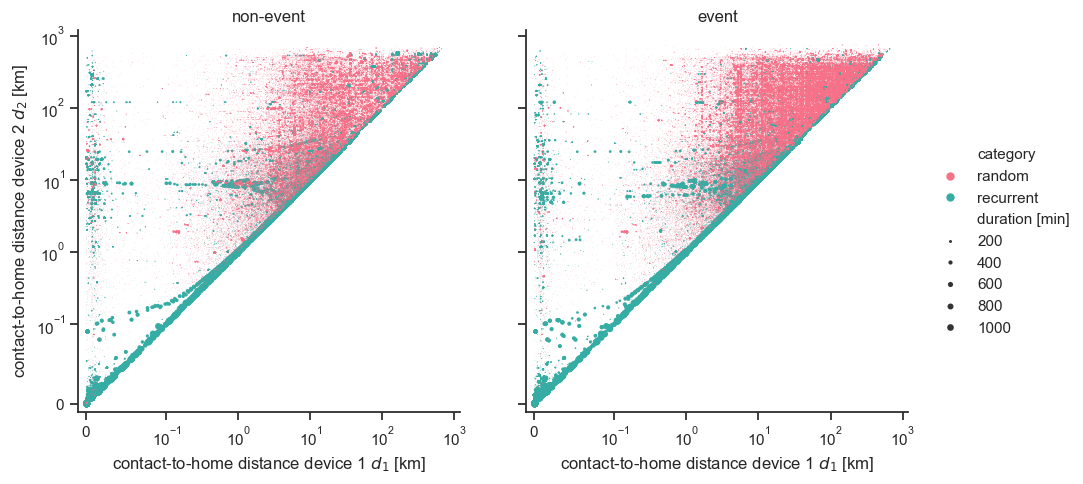

In [24]:
titles = ['non-event', 'event']
g = sns.relplot(
    data=dist_cmp, x="dhome1", y="dhome2",#[dist_cmp.day.isin(days_here)]
    col="event", hue="stability", size="dur", col_order=[False,True],# style="day",
    kind="scatter", alpha=1.,
    palette=sns.husl_palette(2),#"ch:r=-.2,d=.3_r",
    #hue_order=clarity_ranking,
    sizes=(.1, 25), linewidth=0,# (.1, 25)
)
for ax, tit in zip(g.axes.flat, titles):
    ax.set_xscale('symlog', linthresh=1e-1)
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_xlim([-1e-2, 1.2e3])
    ax.set_ylim([-1e-2, 1.2e3])
    ax.set_xlabel(r'contact-to-home distance device 1 $d_1$ [km]')
    ax.set_ylabel(r'contact-to-home distance device 2 $d_2$ [km]')
    ax.set_aspect('equal')
    ax.set_title(tit)
    ax.grid(False)
#g.add_legend(title='category of contact')#, bbox_to_anchor=(1, 1), loc="center left")
lg = g._legend
for tx in lg.texts:
    if tx.get_text() == 'stability':
        tx.set_text('category')
    elif tx.get_text() == '1':
        tx.set_text('recurrent')
    elif tx.get_text() == '0':
        tx.set_text('random')
    elif tx.get_text() == 'dur':
        tx.set_text('duration [min]')
g.tight_layout()

plt.savefig(f'plots/fig6/stable_random_homedist_germany.jpg', bbox_inches='tight', dpi=300)
##plt.savefig(f'plots/fig6/stable_random_homedist_germany.pdf', bbox_inches='tight')
plt.show()

In [25]:
dhhstat = dist_cmp[['event','stability','dhometohome']].copy(deep=True)
dhhstat['stability'] = ['recurrent' if sta==1 else 'random' for sta in dhhstat.stability]
dhhstat['dhometohome_log'] = dhhstat.dhometohome.apply(lambda x: np.log10(1e-3+x))
print(dhhstat.dhometohome.min(), dhhstat.dhometohome.max())
dhhstat

0.0 799.3790716999761


,event,stability,dhometohome,dhometohome_log
0,True,recurrent,79.814211,1.902086
1,True,recurrent,79.814211,1.902086
2,True,recurrent,79.814211,1.902086
3,True,recurrent,79.814211,1.902086
4,True,recurrent,79.814211,1.902086
...,...,...,...,...
287376,False,random,0.150978,-0.818220
287377,False,random,0.150978,-0.818220
287378,False,random,0.150978,-0.818220
287379,False,random,3.787348,0.578450


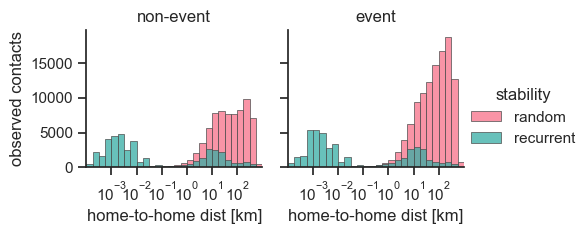

In [26]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(dhhstat, col="event", hue="stability", hue_order=['random','recurrent'], palette=sns.husl_palette(2),#sns.color_palette(),#"tab20c",
                     col_wrap=2, height=2.5, aspect=1, legend_out=True)

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.histplot, "dhometohome", binwidth=.25, binrange=(-4.,3.), multiple="stack",edgecolor=".3", linewidth=.5, log_scale=True,)
grid.set(xlim=[1e-4,1e3], xlabel="home-to-home dist [km]", ylabel="observed contacts")
grid.set(xticks=[1e-3,1e-2,1e-1,1e0,1e1,1e2])

# legend
grid.add_legend()

# Custom formatter: show decimals only when needed
def smart_format(x, _):
    return f"{x:.2f}".rstrip('0').rstrip('.') if x < 10 else f"{int(x)}"

for ax, tit in zip(grid.axes.flat, ['non-event', 'event']):
    ax.set_title(tit)
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(smart_format))

plt.savefig(f'plots/fig6/stable_random_homehomedist_germany_linear.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig6/stable_random_homehomedist_germany_linear.pdf', bbox_inches='tight')
plt.show()

In [27]:
stab_here = 'recurrent'
#stab_here = 'random'
data1 = dhhstat[(~dhhstat.dhometohome.isna()) & (dhhstat.stability==stab_here) & (dhhstat.event==False)].dhometohome_log.tolist()
data2 = dhhstat[(~dhhstat.dhometohome.isna()) & (dhhstat.stability==stab_here) & (dhhstat.event==True)].dhometohome_log.tolist()
print(len(data1), len(data2))

print()
 
statistic, p_value = ks_2samp(data1, data2)
print(f"KS statistic: {statistic:.3f}, p-value: {p_value}")# {p_value:.4f}")

print()

statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value}")# {p_value:.4f}")

#print()
#
#result = anderson_ksamp([data1, data2])
#print(f"AD statistic: {result.statistic}, p-value: {result.significance_level:.4f}")

42171 45187

KS statistic: 0.023, p-value: 4.392552724082281e-10

Mann–Whitney U statistic: 952623827.5, p-value: 0.9643082390265676


In [28]:
catstat = dist_cmp.groupby(['day','event','stability']).pair.apply(lambda x: len(x)).reset_index().drop(columns=['day'])# len(set(x))
catstat['stability'] = ['recurrent' if sta==1 else 'random' for sta in catstat.stability]
catstat['pair'] = catstat.pair.astype(float)
catstat['x'] = catstat.stability.map({'random':1,'recurrent':0})
print(catstat.pair.sum())
catstat

287381.0


,event,stability,pair,x
0,False,random,326.0,1
1,False,recurrent,187.0,0
2,False,random,488.0,1
3,False,recurrent,199.0,0
4,False,random,474.0,1
...,...,...,...,...
263,True,recurrent,176.0,0
264,True,random,1869.0,1
265,True,recurrent,713.0,0
266,True,random,5160.0,1


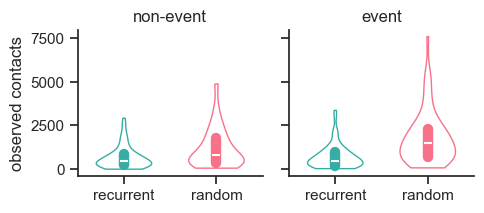

In [29]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(catstat, col="event", hue="stability", hue_order=['random','recurrent'], palette=sns.husl_palette(2),#sns.color_palette(),#"tab20c",
                     col_wrap=2, height=2.5, aspect=1, legend_out=True)

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.violinplot, "x", "pair", orient="v",
               split=False, bw_adjust=1, cut=.1, linewidth=1, order=[0,1],
               fill=False, inner='box', gap=.25, density_norm='width',
               legend=False,
               inner_kws=dict(box_width=7.5, whis_width=0))
grid.set(xlabel="", ylabel="observed contacts")
grid.set(xticks=[0,1], xticklabels=['recurrent', 'random'])

# Custom formatter: show decimals only when needed
def smart_format(x, _):
    return f"{x:.2f}".rstrip('0').rstrip('.') if x < 10 else f"{int(x)}"

for ax, tit in zip(grid.axes.flat, ['non-event', 'event']):
    ax.set_title(tit)
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(smart_format))

plt.savefig(f'plots/fig6/stable_random_homedist_germany_histo.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig6/stable_random_homedist_germany_histo.pdf', bbox_inches='tight')
plt.show()

In [30]:
stab_here = 'recurrent'
#stab_here = 'random'
data1 = catstat[(catstat.stability==stab_here) & (catstat.event==False)].pair.tolist()
data2 = catstat[(catstat.stability==stab_here) & (catstat.event==True)].pair.tolist()
print(len(data1), len(data2))

print()
 
statistic, p_value = ks_2samp(data1, data2)
print(f"KS statistic: {statistic:.3f}, p-value: {p_value:.4f}")

print()

statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value:.4f}")

#print()
#
#result = anderson_ksamp([data1, data2])
#print(f"AD statistic: {result.statistic}, p-value: {result.significance_level:.4f}")

67 67

KS statistic: 0.104, p-value: 0.8617

Mann–Whitney U statistic: 2115.5, p-value: 0.5674


## 1 city

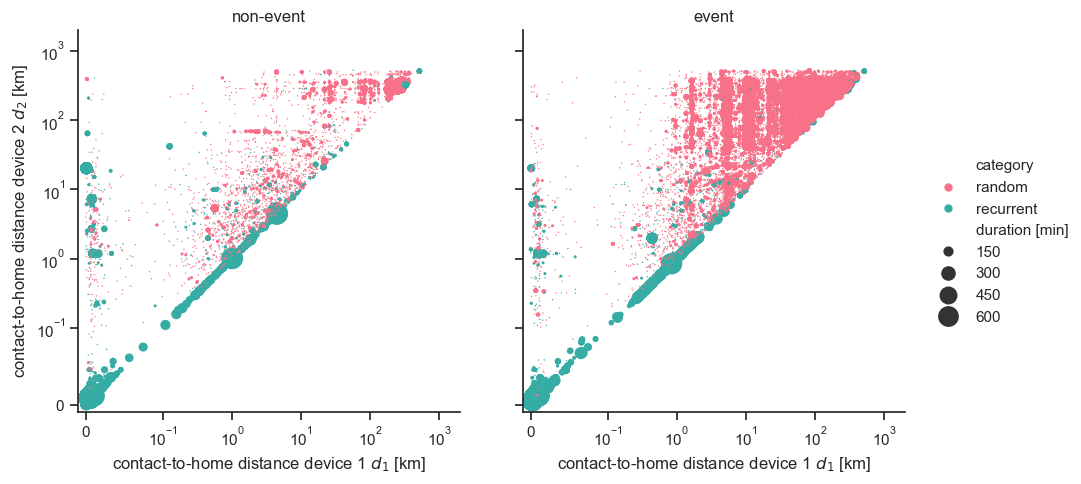

In [31]:
titles = ['non-event', 'event']
g = sns.relplot(
    data=dist_cmp[dist_cmp.city=='Gelsenkirchen'], x="dhome1", y="dhome2",
    col="event", hue="stability", size="dur", col_order=[False,True],# style="day",
    kind="scatter", alpha=1.,
    palette=sns.husl_palette(2),#"ch:r=-.2,d=.3_r",
    #hue_order=clarity_ranking,
    sizes=(1, 250), linewidth=0,# (.1,25)
)
for ax, tit in zip(g.axes.flat, titles):
    ax.set_xscale('symlog', linthresh=1e-1)
    ax.set_yscale('symlog', linthresh=1e-1)
    ax.set_xlim([-1e-2, 2e3])
    ax.set_ylim([-1e-2, 2e3])
    ax.set_xlabel(r'contact-to-home distance device 1 $d_1$ [km]')
    ax.set_ylabel(r'contact-to-home distance device 2 $d_2$ [km]')
    ax.set_aspect('equal')
    ax.set_title(tit)
    ax.grid(False)
#g.add_legend(title='category of contact')#, bbox_to_anchor=(1, 1), loc="center left")
lg = g._legend
for tx in lg.texts:
    if tx.get_text() == 'stability':
        tx.set_text('category')
    elif tx.get_text() == '1':
        tx.set_text('recurrent')
    elif tx.get_text() == '0':
        tx.set_text('random')
    elif tx.get_text() == 'dur':
        tx.set_text('duration [min]')
g.tight_layout()

plt.savefig(f'plots/fig6/stable_random_homedist_city.jpg', bbox_inches='tight', dpi=300)
##plt.savefig(f'plots/fig6/stable_random_homedist_city.pdf', bbox_inches='tight')
plt.show()

In [32]:
dhhstat = dist_cmp[dist_cmp.city=='Gelsenkirchen'][['event','stability','dhometohome']].copy(deep=True)
dhhstat['stability'] = ['recurrent' if sta==1 else 'random' for sta in dhhstat.stability]
dhhstat['dhometohome_log'] = dhhstat.dhometohome.apply(lambda x: np.log10(1e-3+x))
print(dhhstat.dhometohome.min(), dhhstat.dhometohome.max())
dhhstat

6.580860474305e-05 741.6465928836146


,event,stability,dhometohome,dhometohome_log
141,True,recurrent,0.000097,-2.959779
142,True,recurrent,0.000097,-2.959779
143,True,recurrent,0.000097,-2.959779
144,True,recurrent,0.000097,-2.959779
145,True,recurrent,0.000097,-2.959779
...,...,...,...,...
260842,False,random,44.986154,1.653089
260843,False,random,35.003745,1.544127
260844,False,random,35.003745,1.544127
260845,False,random,1.808413,0.257538


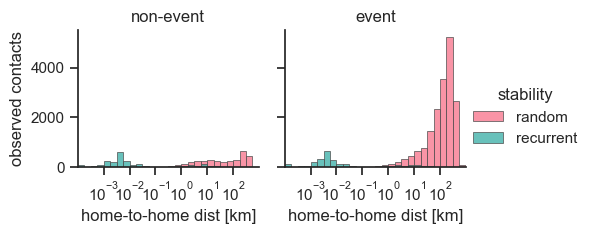

In [33]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(dhhstat, col="event", hue="stability", hue_order=['random','recurrent'], palette=sns.husl_palette(2),#sns.color_palette(),#"tab20c",
                     col_wrap=2, height=2.5, aspect=1, legend_out=True)

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.histplot, "dhometohome", binwidth=.25, binrange=(-4.,3.), multiple="stack",edgecolor=".3", linewidth=.5, log_scale=True,)# binwidth=.25,
grid.set(xlim=[1e-4,1e3], xlabel="home-to-home dist [km]", ylabel="observed contacts")
grid.set(xticks=[1e-3,1e-2,1e-1,1e0,1e1,1e2])

# legend
grid.add_legend()

# Custom formatter: show decimals only when needed
def smart_format(x, _):
    return f"{x:.2f}".rstrip('0').rstrip('.') if x < 10 else f"{int(x)}"

for ax, tit in zip(grid.axes.flat, ['non-event', 'event']):
    ax.set_title(tit)
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(smart_format))

plt.savefig(f'plots/fig6/stable_random_homehomedist_city_linear.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig6/stable_random_homehomedist_city_linear.pdf', bbox_inches='tight')
plt.show()

In [34]:
#stab_here = 'recurrent'
stab_here = 'random'
data1 = dhhstat[(~dhhstat.dhometohome.isna()) & (dhhstat.stability==stab_here) & (dhhstat.event==False)].dhometohome_log.tolist()
data2 = dhhstat[(~dhhstat.dhometohome.isna()) & (dhhstat.stability==stab_here) & (dhhstat.event==True)].dhometohome_log.tolist()
print(len(data1), len(data2))

print()
 
statistic, p_value = ks_2samp(data1, data2)
print(f"KS statistic: {statistic:.3f}, p-value: {p_value}")# {p_value:.4f}")

print()

statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value}")# {p_value:.4f}")

#print()
#
#result = anderson_ksamp([data1, data2])
#print(f"AD statistic: {result.statistic}, p-value: {result.significance_level:.4f}")

3453 18047

KS statistic: 0.307, p-value: 2.7024162933253317e-242

Mann–Whitney U statistic: 22631762.5, p-value: 1.2850547704987703e-143


In [35]:
catstat = dist_cmp[dist_cmp.city=='Gelsenkirchen'].groupby(['day','event','stability']).pair.apply(lambda x: len(x)).reset_index().drop(columns=['day'])# len(set(x))
catstat['stability'] = ['recurrent' if sta==1 else 'random' for sta in catstat.stability]
catstat['pair'] = catstat.pair.astype(float)
catstat['x'] = catstat.stability.map({'random':1,'recurrent':0})
catstat

,event,stability,pair,x
0,False,random,230.0,1
1,False,recurrent,187.0,0
2,False,random,262.0,1
3,False,recurrent,171.0,0
4,True,random,830.0,1
...,...,...,...,...
63,True,recurrent,136.0,0
64,True,random,1574.0,1
65,True,recurrent,176.0,0
66,True,random,898.0,1


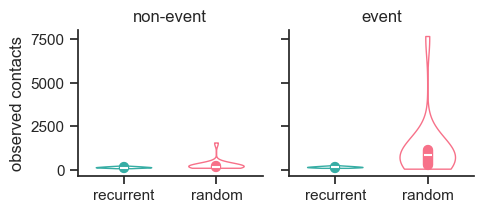

In [36]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(catstat, col="event", hue="stability", hue_order=['random','recurrent'], palette=sns.husl_palette(2),#sns.color_palette(),#"tab20c",
                     col_wrap=2, height=2.5, aspect=1, legend_out=True)

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.violinplot, "x", "pair", orient="v",
               split=False, bw_adjust=1, cut=.1, linewidth=1, order=[0,1],
               fill=False, inner='box', gap=.25, density_norm='width',
               legend=False,
               inner_kws=dict(box_width=7.5, whis_width=0))
grid.set(xlabel="", ylabel="observed contacts")
grid.set(xticks=[0,1], xticklabels=['recurrent', 'random'])

# Custom formatter: show decimals only when needed
def smart_format(x, _):
    return f"{x:.2f}".rstrip('0').rstrip('.') if x < 10 else f"{int(x)}"

for ax, tit in zip(grid.axes.flat, ['non-event', 'event']):
    ax.set_title(tit)
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(smart_format))

plt.savefig(f'plots/fig6/stable_random_homedist_city_histo.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig6/stable_random_homedist_city_histo.pdf', bbox_inches='tight')
plt.show()

In [37]:
#stab_here = 'recurrent'
stab_here = 'random'
data1 = catstat[(catstat.stability==stab_here) & (catstat.event==False)].pair.tolist()
data2 = catstat[(catstat.stability==stab_here) & (catstat.event==True)].pair.tolist()
print(len(data1), len(data2))

print()
 
statistic, p_value = ks_2samp(data1, data2)
print(f"KS statistic: {statistic:.3f}, p-value: {p_value:.4f}")

print()

statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"Mann–Whitney U statistic: {statistic}, p-value: {p_value:.4f}")

#print()
#
#result = anderson_ksamp([data1, data2])
#print(f"AD statistic: {result.statistic}, p-value: {result.significance_level:.4f}")

17 17

KS statistic: 0.647, p-value: 0.0012

Mann–Whitney U statistic: 38.5, p-value: 0.0003


In [38]:
len(dist_cmp[(dist_cmp.day.isin(days_here)) & (dist_cmp.event==True) & (dist_cmp.stability==0)])

83031

In [39]:
len(dist_cmp[(dist_cmp.day.isin(days_here)) & (dist_cmp.event==True) & (dist_cmp.stability==1)])

35186

In [40]:
len(dist_cmp[(dist_cmp.day.isin(days_here)) & (dist_cmp.event==False) & (dist_cmp.stability==0)])

77794

In [41]:
len(dist_cmp[(dist_cmp.day.isin(days_here)) & (dist_cmp.event==False) & (dist_cmp.stability==1)])

43638